In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
sc = pyspark.SparkContext(appName="TrafficStream")
from pyspark.streaming import StreamingContext
# Where the web scraper script is outputting files
streamFilePath = "file:/Users/nandhitharaghuram/Desktop/Hackathon/Outputfiles/"

# Number of seconds for Spark to ingest the data files
microBatchSeconds = 30

In [3]:
ssc = StreamingContext(sc, microBatchSeconds)  # Seconds per micro-batch
sqlContext = pyspark.SQLContext(sc)

In [4]:

# Data manipulation
import pandas as pd
import numpy as np

# Timestamps
from datetime import datetime, timedelta

# City network and plots
import osmnx as ox, geopandas as gdp
import matplotlib.pyplot as plt

# To replace output plots for streaming
from IPython import display

# Sets intervals for updating the plot
import time

%matplotlib inline

In [5]:
# Retrieving the network for Manhattan
manhattan = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')

# Projecting the network for a top-down view
manhattan_projected = ox.project_graph(manhattan)

Non-projected:


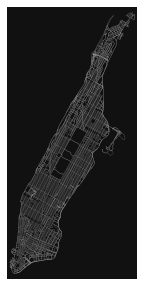

Projected:


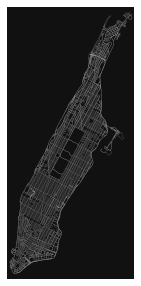

In [6]:
print('Non-projected:')
fig1 = ox.plot_graph(manhattan, figsize=(5,5), node_size=0, 
              node_alpha=1,edge_linewidth=0.2, dpi=100)

print('Projected:')
fig2 = ox.plot_graph(manhattan_projected, figsize=(5,5), node_size=0, 
              node_alpha=1,edge_linewidth=0.2, dpi=100)

In [7]:
from pyspark.sql.types import StructType,StructField,IntegerType,StringType
c = sc.textFile("/Users/nandhitharaghuram/Desktop/Hackathon/Outputfiles/*").map(lambda line: line.split(',')) \
                   .filter(lambda line: line[11] == 'Manhattan')  # Removes other boroughs
t = c.map(lambda line: (line[0], line[4], line[6], line[11]))
schema = StructType([
        StructField("id", StringType(), True),
        StructField("DataAsOf", StringType(), True),
        StructField("linkPoints", StringType(), True),
        StructField("Borough", StringType(), True)
        ])
DFtemp = sqlContext.createDataFrame(t, schema)
DF=DFtemp
DF.registerTempTable("trafficTemp")

In [14]:
df = sqlContext.sql("select * from trafficTemp").toPandas()
df.columns = ['id', 'Date', 'linkPoints', 'Borough']
df['splitPoints'] = df['linkPoints'].apply(lambda x: x.split(' '))
idNodes = []
for x,y in zip(df['splitPoints'], df['id']):
    for a in np.arange(len(x)):
        idNodes.append((y, x[a]))
df = pd.DataFrame(idNodes, columns=['id', 'LatLong'])
df = df.replace('', np.NaN).dropna()
df['Latitude'] = df['LatLong'].apply(lambda x: x.split(';')[0])
df['Longitude'] = df['LatLong'] \
    .apply(lambda x: x.split(';')[1] if len(x.split(';')) > 1 else None)
df = df[df['Longitude'] != '-'][['id', 'Latitude', 'Longitude']].astype(float)
nodes = []
for row in df.iterrows():
    nearest_node = ox.get_nearest_node(manhattan, (df['Latitude'][row[0]], 
                                                   df['Longitude'][row[0]]))
#     print(nearest_node)
    nodes.append(nearest_node)
df['Node'] = nodes
df['NodeId'] = nodes
df = df.dropna()

In [15]:
df_node =  df[['Node','id']].groupby(['Node']).count().reset_index()
df_node

,Node,id
0,4.242196e+07,39
1,4.242202e+07,39
2,4.242221e+07,273
3,4.242227e+07,39
4,4.242290e+07,39
...,...,...
174,7.684226e+09,78
175,7.684226e+09,156
176,8.110710e+09,156
177,8.276469e+09,78


In [16]:
import folium
mapit = folium.Map(location=[40.693943, -73.985880],tiles='OpenStreetMap',zoom_start=8)
lat = df['Latitude'].tolist()
long = df['Longitude'].tolist()
for i in range(len(lat)):
    v1 = lat[i]
    v2 = long[i]
    folium.Marker( location=[ v1,v2 ], fill_color='#43d9de', radius=8 ).add_to( mapit )
# crowd = []
# for row in df_node.iterrows():
#     if df_node['id'][row[0]] >=20:
#         crowd.append(df_node['Node'][row[0]])
# nodes = []
# len(crowd) 
mapit.save( 'map_folium.html')

Plot Generated:
 2021-01-03 
 03:01:08 EST


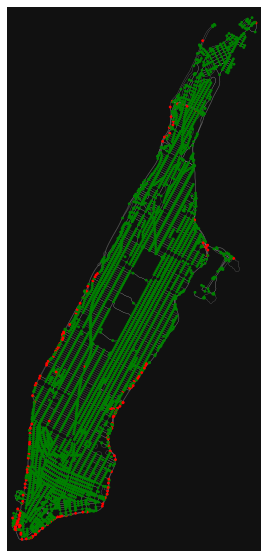

<AxesSubplot:>

In [11]:
while True:
    try:
        # Putting our streaming data from the temporary table into a data frame
        df = sqlContext.sql("select * from trafficTemp").toPandas()
        df.columns = ['id', 'Date', 'linkPoints', 'Borough']
        df['splitPoints'] = df['linkPoints'].apply(lambda x: x.split(' '))
        idNodes = []
        for x,y in zip(df['splitPoints'], df['id']):
            for a in np.arange(len(x)):
                idNodes.append((y, x[a]))
        df = pd.DataFrame(idNodes, columns=['id', 'LatLong'])
        df = df.replace('', np.NaN).dropna()
        df['Latitude'] = df['LatLong'].apply(lambda x: x.split(';')[0])
        df['Longitude'] = df['LatLong'] \
            .apply(lambda x: x.split(';')[1] if len(x.split(';')) > 1 else None)
        df = df[df['Longitude'] != '-'][['id', 'Latitude', 'Longitude']].astype(float)
        nodes = []
        for row in df.iterrows():
            nearest_node = ox.get_nearest_node(manhattan, (df['Latitude'][row[0]],df['Longitude'][row[0]]))
            nodes.append(nearest_node)
        df['Node'] = nodes
        df_node =  df[['Node','id']].groupby(['Node']).count().reset_index()
        crowd = []
        avail = []
        for row in df_node.iterrows():
            node = df_node['Node'][row[0]]
            if df_node['id'][row[0]]>=5:
                crowd.append(node)
            else:
                avail.append(node)
        nc = ['r' if node in crowd
             else 'g'
             for node in manhattan_projected.nodes()]

        # Timestamp
        EST = datetime.utcnow() - timedelta(hours=5)  # Calculating Eastern Standard Time
        print('Plot Generated:\n {:%Y-%m-%d \n %H:%M:%S} EST'.format(EST))

        # Plotting the map
        fig, ax = ox.plot_graph(manhattan_projected, figsize=(10,10), node_size=8, 
                                node_alpha=1,edge_linewidth=0.2, dpi=100, node_color=nc)
        # Sets the output
        display.display(ax)
        display.clear_output(wait=True)
        
        time.sleep(microBatchSeconds)  # Number of seconds between refreshes
    
    except KeyboardInterrupt:
        break